#### Imports ####

In [1]:
import os
import torch
import numpy as np
import normflows as nf
import hydra
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm

from flows import RealNVP, NeuralSplineFlow
from prefflow import PrefFlow
from plotter import Plotter
from target import set_up_problem
from misc import convert_to_ranking

#### Load config file to set-up experiment and algorithm details ####

In [2]:
with hydra.initialize(version_base=None, config_path="conf"):
   os.chdir(os.getcwd())
   output_folder = os.path.join(os.getcwd(), 'temporary_outputs')
   cfg = hydra.compose(config_name="config.yaml",overrides=["+db=mysql"])
if not cfg.plot.showduringtraining: # Show plots?
    matplotlib.use('Agg') 

#### Device and Precision ####

In [3]:
torch.set_default_dtype(torch.float64 if cfg.device.precision_double else torch.float32)
device = torch.device(cfg.device.device)

#### Random seeds ####

In [4]:
import random
torch.manual_seed(cfg.exp.seed)
np.random.seed(cfg.exp.seed)
random.seed(cfg.exp.seed)

  #### Target belief density ####

In [5]:
target_name = cfg.exp.target
D = cfg.exp.d
target, bounds, uniform, D, normalize = set_up_problem(target_name,D)

#### Base distribution and Flow architecture ####

In [6]:
q0 = nf.distributions.DiagGaussian(D, trainable=False)
nflows = cfg.params.nflows
if cfg.params.flow == "realnvp":
    nfm = RealNVP(nflows,D,q0,device,cfg.device.precision_double)
if cfg.params.flow == "neuralsplineflow":
    nfm = NeuralSplineFlow(nflows,D,q0,device,cfg.device.precision_double)

#### Data generation 1/2 ####

In [7]:
target_sample = target.sample(10000)
target_mean = target_sample.mean(dim=0).double()
target_std = target_sample.std(dim=0).double()
def sample_alternatives(n,k=2,distribution="uniform"):
        if distribution=="uniform":
            return uniform.sample(torch.tensor([k*n])).to(device)
        elif distribution=="target":
            return target.sample(k*n).to(device)
        elif distribution=="mixture_uniform_gaussian":
            target_gaussian = torch.distributions.MultivariateNormal(target_mean, target_std*torch.eye(D))
            howoftentarget = cfg.exp.mixture_success_prob
            samples = []  
            for _ in range(k):
                if np.random.sample() <= howoftentarget:
                    x = target_gaussian.sample((n,))
                else:
                    x = uniform.sample(torch.tensor([n])).to(device)
                samples.append(x)
            return torch.cat(samples, dim=0)
def expert_feedback_pairwise(comp,s=None):
    noise = (0,0) if (s is None) else torch.distributions.Exponential(s).sample((2,)).to(device)
    logprobs = target.log_prob(comp).to(device)
    return torch.ge(logprobs[0] + noise[0],logprobs[1] + noise[1]).long().view(1).to(device)
def expert_feedback_ranking(alternatives,s=None):
    k = alternatives.shape[0]
    noise = torch.distributions.Exponential(s).sample((k,)).to(device)
    logprobs = target.log_prob(alternatives).to(device) + noise
    _, ranking_inds = torch.sort(logprobs, descending=True)
    return ranking_inds.view(k).to(device)
def generate_dataset(N,s=None,distribution="uniform"):
    X = sample_alternatives(1,2,distribution)
    Y = expert_feedback_pairwise(X,s)
    X = X.unsqueeze(2) #add new dimension, which indicates sample index
    if N > 1:
        for i in range(0,N-1):
            comp = sample_alternatives(1,2,distribution)
            X = torch.cat((X,comp.unsqueeze(2)),2)
            Y = torch.cat((Y,expert_feedback_pairwise(comp,s)),0)
    return X,Y #X.shape = (2,D,N) = (comp,space dimensions, number of comps)
def generate_dataset_ranking(N,k,s=None,distribution="uniform"):
    X = sample_alternatives(1,k,distribution)
    Y = expert_feedback_ranking(X,s).view(1,k)
    X = X.unsqueeze(2) #add new dimension, which indicates sample index
    if N > 1:
        for i in range(0,N-1):
            alternatives = sample_alternatives(1,k,distribution)
            X = torch.cat((X,alternatives.unsqueeze(2)),2)
            Y = torch.cat((Y,expert_feedback_ranking(alternatives,s).view(1,k)),0)
    Xdata = convert_to_ranking(X.numpy(),Y.numpy())
    #return X,Y #X.shape = (k,D,N) = (alternatives,space dimensions, number of rankings)
    return torch.from_numpy(Xdata).view(k,-1,N) 

#### Data generation 2/2 ####

In [8]:
n = cfg.data.n
true_s = cfg.exp.true_s
ranking = True if cfg.data.k > 2 else False
if ranking:
    k = cfg.data.k
    dataset = generate_dataset_ranking(N=n,k=k,s=true_s,distribution=cfg.exp.lambda_dist)
else:
    dataset = generate_dataset(N=n,s=true_s,distribution=cfg.exp.lambda_dist)
        
def minibatch(dataset,batch_size,ranking):
    indices = torch.randperm(n)[:batch_size]
    batch = (dataset[0][:,:,indices],dataset[1][indices]) if not ranking else dataset[:,:,indices]
    return batch

  #### Initialize preferential flow ####

In [9]:
prefflow = PrefFlow(nfm,D=D,s=cfg.modelparams.s,ranking=ranking,device=device,precision_double=cfg.device.precision_double)

#### Initialize optimizer ####

In [10]:
loss_hist = np.array([])
batch_size = cfg.params.batch_size
optimizer = getattr(torch.optim, cfg.params.optimizer.capitalize())
optimizer_prefflow = optimizer([{'params':prefflow.parameters()}],lr=cfg.params.lr, weight_decay=cfg.params.weight_decay)

#### Initialize plotter ####

In [11]:
plotter = Plotter(D,bounds)

### SGD FS-MAP ###

In [12]:
print("Dimension:", D)
print("Number of preferences", n)

for it in tqdm(range(cfg.params.max_iter),disable=not cfg.plot.progressbar_show):
    
    #Sample minibatch
    batch = minibatch(dataset,batch_size,ranking)
    #Update flow parameters
    prefflow.train()
    optimizer_prefflow.zero_grad()
    loss = -prefflow.logposterior(batch,cfg.modelparams.weightprior)
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer_prefflow.step()
    loss_hist = np.append(loss_hist, loss.to('cpu').detach().numpy())

    # Plot learned density
    if (it + 1) % cfg.plot.show_iter == 0:
        print("loss: " + str(loss.to('cpu').detach().numpy()))
        # if cfg.plot.showdatapoints:
        #     showdata = minibatch(dataset,batch_size=n,ranking=ranking)
        #     probmassinarea = plotter.plot_moon(target,prefflow,data=showdata,cfg=cfg)
        # else:
        #     probmassinarea = plotter.plot_moon(target,prefflow,data=None,cfg=cfg)
        # plt.show()

Dimension: 2
Number of preferences 100


 13%|█▎        | 2504/20000 [01:00<06:43, 43.37it/s]

loss: 38.80146967766258


 25%|██▌       | 5004/20000 [01:57<05:42, 43.77it/s]

loss: 31.251602718083554


 38%|███▊      | 7509/20000 [02:55<04:42, 44.26it/s]

loss: 35.412514124615086


 50%|█████     | 10007/20000 [03:53<03:46, 44.14it/s]

loss: 28.326775644587734


 63%|██████▎   | 12507/20000 [04:51<02:49, 44.15it/s]

loss: 30.660624124394577


 75%|███████▌  | 15007/20000 [05:48<01:54, 43.68it/s]

loss: 30.20536620669992


 88%|████████▊ | 17505/20000 [06:46<00:56, 44.01it/s]

loss: 27.78123931310371


100%|██████████| 20000/20000 [07:43<00:00, 43.15it/s]

loss: 31.819955767298246


In [13]:
from sklearn.decomposition import PCA
from scipy.stats import kendalltau
import torch

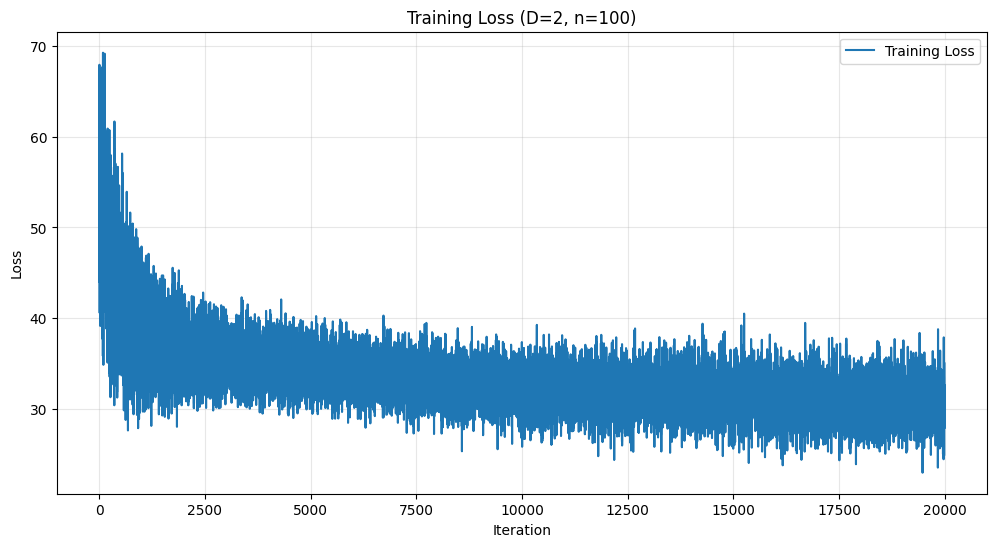

In [14]:
# -------- 1. Plot Learning Curve --------
plt.figure(figsize=(12, 6))
plt.plot(loss_hist, label='Training Loss')
plt.title(f"Training Loss (D={D}, n={n})")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

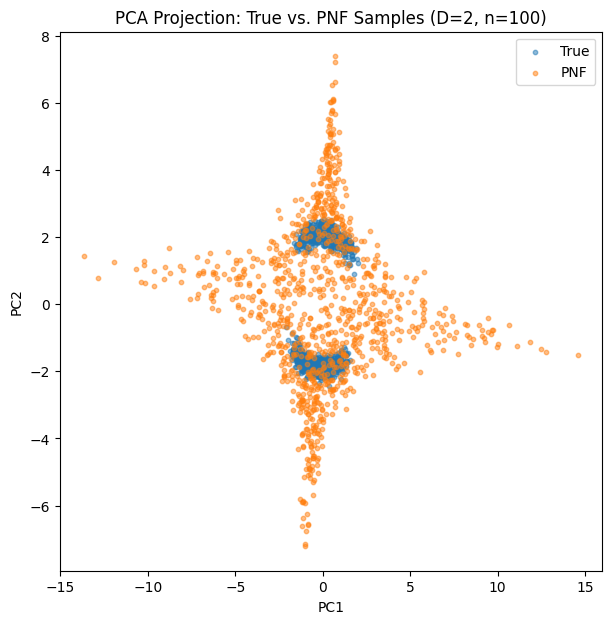

In [15]:
# -------- 2. Overlay PCA Projections: True vs. Learned --------
# Sample from both true and learned distributions
n_vis = 1000
true_samples = target.sample(n_vis).detach().cpu().numpy()
pnf_samples = prefflow.sample(n_vis)[0].detach().cpu().numpy()

# Fit PCA on the combined data
pca = PCA(n_components=2).fit(np.vstack([true_samples, pnf_samples]))
true_proj = pca.transform(true_samples)
pnf_proj = pca.transform(pnf_samples)

plt.figure(figsize=(7, 7))
plt.scatter(true_proj[:, 0], true_proj[:, 1], alpha=0.5, label="True", s=10)
plt.scatter(pnf_proj[:, 0], pnf_proj[:, 1], alpha=0.5, label="PNF", s=10)
plt.title(f"PCA Projection: True vs. PNF Samples (D={D}, n={n})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.show()

In [16]:
# -------- 3. KL Divergence Estimate (Monte Carlo) --------
# KL(PNF || True): E_PNF [log q(x) - log p(x)]
pnf_samples_torch = torch.from_numpy(pnf_samples).to(device)
with torch.no_grad():
    logq = prefflow.log_prob(pnf_samples_torch).detach().cpu().numpy()
    logp = target.log_prob(pnf_samples_torch).detach().cpu().numpy()
kl_estimate = np.mean(logq - logp)
print(f"Estimated KL(PNF || True) on PNF samples: {kl_estimate:.4f}")

Estimated KL(PNF || True) on PNF samples: 86.3851


In [17]:
# -------- 4. Log-Likelihood of Held-Out Preferences --------
# Generate held-out preference queries
def heldout_log_likelihood(target, prefflow, n_queries=100, k=2):
    ll_list = []
    for _ in range(n_queries):
        # Generate two alternatives from the uniform or true distribution
        x = target.sample(k).to(device)
        # True label (by true target)
        logprobs = target.log_prob(x)
        y_true = int(logprobs[0] > logprobs[1])
        # Model predicted probabilities
        logf, _ = prefflow.f(x)
        prob_01 = torch.sigmoid(logf[0] - logf[1]).cpu().item()
        ll = np.log(prob_01 if y_true else 1 - prob_01 + 1e-10)
        ll_list.append(ll)
    return np.mean(ll_list)

heldout_ll = heldout_log_likelihood(target, prefflow, n_queries=100)
print(f"Mean log-likelihood on 100 held-out preferences: {heldout_ll:.4f}")

Mean log-likelihood on 100 held-out preferences: -0.6710


In [18]:
# -------- 5. Ranking Consistency (Kendall tau) --------
def ranking_consistency(target, prefflow, n_queries=50, k=5):
    tau_list = []
    for _ in range(n_queries):
        x = target.sample(k).to(device)
        u_true = target.log_prob(x).detach().cpu().numpy()
        logf, _ = prefflow.f(x)
        u_pred = logf.detach().cpu().numpy()
        tau, _ = kendalltau(u_true, u_pred)
        tau_list.append(tau)
    return np.nanmean(tau_list)

mean_tau = ranking_consistency(target, prefflow, n_queries=50, k=min(5, D))
print(f"Mean Kendall tau (ranking consistency, k=5): {mean_tau:.4f}")

Mean Kendall tau (ranking consistency, k=5): 0.0000
